<a href="https://colab.research.google.com/github/FauxGrit/Titanic-Fairness/blob/main/Fairness_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: A simple approach to audit machine learning models for bias and fairness

*I think unconscious bias is one of the hardest things to get at.*
   -- Ruth Bader Ginsburg

Mama's don't let your babies grow up to be supreme court justices. Let em be data scientists instead. Because there are a gathering number of open source toolkits that make auditing your models for bias and fairness a snap.

This is a tutorial to demonstrate how to audit machine learning models. It is an extension of the first tutorial in Kaggle aimed at building a model to predict survival on the Titanic. It uses Aequitas, an open source bias audit toolkit, to provide easy to understand visualizations and detailed fairness metrics for any model.

Aequitas documentation: http://www.datasciencepublicpolicy.org/our-work/tools-guides/aequitas/ 

### Importing Necessary Libraries

In [1]:
!pip install aequitas==0.42.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 4.0 MB/s 
     |████████████████████████████████| 161 kB 46.0 MB/s 
     |████████████████████████████████| 97 kB 6.0 MB/s 
     |████████████████████████████████| 727 kB 8.9 MB/s 
     |████████████████████████████████| 456 kB 10.7 MB/s 
     |████████████████████████████████| 45 kB 3.5 MB/s 
     |████████████████████████████████| 83 kB 1.4 MB/s 
     |████████████████████████████████| 220 kB 51.8 MB/s 
     |████████████████████████████████| 2.8 MB 38.4 MB/s 
     |████████████████████████████████| 3.2 MB 43.9 MB/s 
  Created wheel for Flask-Bootstrap: filename=Flask_Bootstrap-3.3.7.1-py3-none-any.whl size=460123 sha256=52c7df65b4434241ed94a272eab1fcaa292e9b0844ae0dfc31532870c4f41509
  Stored in directory: /root/.cache/pip/wheels/f2/a3/85/fe8b65a65a447c9906e3b7edb7d9e6c74dfa9c8425c3dd3007
  Created wheel for markdown2: filename=markdown2-2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn import metrics as sklearn_metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap

# Load Data

We will use the Titanic data set from Kaggle. It it a widely used data set intended as a first introduction to predictive modeling and Kaggle competitions.

https://www.kaggle.com/code/alexisbcook/titanic-tutorial


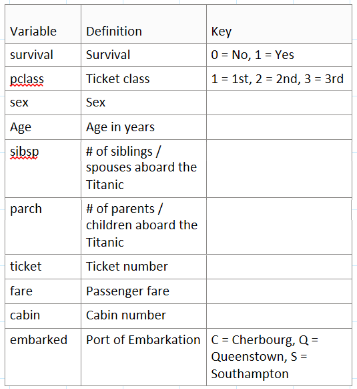

**Variable Notes**
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [3]:
data_url = 'https://raw.githubusercontent.com/FauxGrit/Titanic-Fairness/main/train.csv'
df0 = pd.read_csv(data_url)
df0.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Print shape of dataframe to determine number of rows and columns
print("Raw Titanic Data: \n\nNumber of Rows: ", df0.shape[0], "\nNumber of columns: ", df0.shape[1])

Raw Titanic Data: 

Number of Rows:  891 
Number of columns:  12


# Data Preparation

### Create Feature to Explore Fairness/Bias

We will create a feature to use to explore bias in our model. We could use an existing variable like Sex or Passenger Class (proxy for wealth).  We will create a new feature based on age to explore if there is a bias for, or against, children.

In [5]:
# Create a binary feature to indicate if the passanger is 18 or younger
df0['Children'] = 0
df0.loc[df0['Age'] < 19, 'Children'] = 1
# df0.head()

### Deal with Missing Data
Use imputed values for the numerical fields based on the mean. For categorical data fill with a new category called 'Empty'.

In [6]:
# Fill NaN values
df0['Age'] = df0['Age'].fillna(df0['Age'].mean())
df0['Fare'] = df0['Fare'].fillna(df0['Fare'].mean())
df0['Embarked'] = df0['Embarked'].fillna('Empty')
# df0.head()

### Deal with Categorical Data
Use get_dummies from Pandas as an easy way to do one hot encoding. This means to generate a new binary feature for each categorical value. 

For example, Sex has two possible values: male and female. So two new binary features are created called Sex_male and Sex_female.

In [7]:
df1 = pd.get_dummies(data=df0, columns=['Sex','Embarked'])
# df1.head()

### Drop Columns that are not Needed
We can drop Sex_female because it is redundent with Sex_male. The other fields are not material to our simple model exercise.

In [8]:
# Drop 'PassengerId','Name','Ticket','Cabin' since not useful
df1.drop(['PassengerId','Name','Ticket','Cabin', 'Sex_female'], axis=1, inplace=True)
#df1.head()

###Basic Inspection of Prepped Dataframe

In [9]:
df1.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Children,Sex_male,Embarked_C,Embarked_Empty,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,0,1
1,1,1,38.0,1,0,71.2833,0,0,1,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,0,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,0,1


**Observations from basic statics:**


*   38% total survival rate (from mean of Survuved feature)
*   16% of passengers are children (18 or younger)
* 65% of passengers are men



In [10]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.000000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.000000,3.0,3.0000
Age,891.0,29.699118,13.002015,0.42,22.0000,29.699118,35.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.000000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.000000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.454200,31.0,512.3292
Children,891.0,0.156004,0.363063,0.00,0.0000,0.000000,0.0,1.0000
Sex_male,891.0,0.647587,0.477990,0.00,0.0000,1.000000,1.0,1.0000
Embarked_C,891.0,0.188552,0.391372,0.00,0.0000,0.000000,0.0,1.0000
Embarked_Empty,891.0,0.002245,0.047351,0.00,0.0000,0.000000,0.0,1.0000


### Separate features from response for predictive modeling

X is an array that holds predictive features.
y is an array that holds the response feature. 1 for survival and otherwise 0.

In [11]:
#Separate Input & Response Variables
X = df1.iloc[:,df1.columns != 'Survived'].values
y = df1.iloc[:, 0].values

### Split into Training and Test
We are reserving 25% for testing. Larger than usual because we want a larger population of errors to study for fairness.

In [12]:
#Split into Training / Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

### Scale data
It's generally a good idea to scale and normalize data for machine learning models.

In [13]:
# Scale and Normalize Data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#Prep for Aequitas: Define Fairness Objectives
This is the critical step and framework is often specific to each use case. The following links are useful resources to assist in quantifying fairness metrics:
* http://www.datasciencepublicpolicy.org/wp-content/uploads/2021/04/Fairness-Full-Tree.png
* https://fairlearn.org/main/user_guide/assessment/index.html

For our contrived example, we can use the fairness tree in the 1st link, to think through our survival classification models for children. We decide that False Postive Rate (fpr) is the fairness metric of interest. 

**We want to know if our model FALSELY predicts survival of children at a higher rate than the general population of passengers on the Titanic.**

In our contrived example, where we use our model to inform passenger's about to embark on the Titanic, we want to be fair to children we predict will survive the iceberg.

### Aequitas setup:
* Define Attributes we care about as "Age_Level", we can list multiple
* Define the reference group as "Adults"
* Define metrics to evaluate as "fpr" for False Positive Rate
* Define our disparity tolerance as 1.2 for 20% tolerance 

In [14]:
# Set attributes to audit as "Age_Level" and the reference group to "Adults"
attributes_and_reference_groups={'Age_Level': 'Adults'}
attributes_to_audit = list(attributes_and_reference_groups.keys())

# False Positive Rate --> error rate when predicting survival
metrics = ['fpr']

# Used in visualization to define tolerance for disparity
disparity_tolerance = 1.2

###Format Aequitas Dataframe and Initialize
The Aequitas toolkit requires a dataframe with the following columns:
* 'score': the model predictions as binary data of 1 for survival or 0 for not
* 'label_value': the actual values as binary data of 1 for survival or 0 for not
* attribute(s): features to explore for fairness. Can be categorical as in our case with 'Age_Level'. Can also be continuous. In this case, Aequitas will bin into quartiles.

Documentation for formatting the input dataframe: https://dssg.github.io/aequitas/input_data.html

In [15]:
# Convert arrays back into a dataframe for Aequtas consumption
df_fair = pd.DataFrame(X_test, columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Children',
       'Sex_male', 'Embarked_C', 'Embarked_Empty', 'Embarked_Q', 'Embarked_S'])

# Add the required column for 'label_value'
df_fair['label_value'] = y_test

# Convert Children binary data into Age_Level column with categical data for clarity in visualization
df_fair['Age_Level'] = 'Adults'
df_fair.loc[df_fair['Children'] > 0, 'Age_Level'] = 'Children'

# df_fair.tail(10)

# Initialize Aequitas classes
g = Group()
b = Bias()

#Random Forrest Classifier

### Initialize and Fit Classification Model
Fit model using training data and associated labels.

In [16]:
# Initialize and fit model
rf = RandomForestClassifier(max_depth=3, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=0)

In [17]:
# Test Data
sklearn_metrics.confusion_matrix(y_test, rf.predict(X_test))

array([[129,  10],
       [ 29,  55]])

###Plot Confusion Matrix
Thanks to Stack Vidhya for code snippet. https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/ 

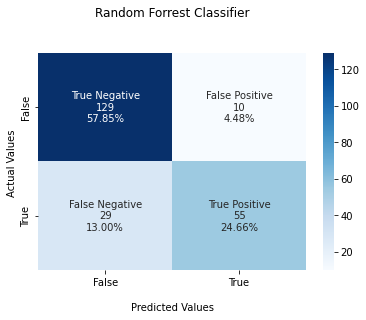

Accuracy:  82.51%


In [18]:
cf_matrix = sklearn_metrics.confusion_matrix(y_test, rf.predict(X_test))

cfm_labels = ['True Negative','False Positive','False Negative','True Positive']

cfm_values = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

cfm_percent = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(cfm_labels,cfm_values,cfm_percent)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Random Forrest Classifier\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

print('Accuracy: ', '{percent:.2%}'.format(percent=rf.score(X_test, y_test)))

In [19]:
df_fair['score'] = rf.predict(X_test)

# get_crosstabs returns a dataframe of the group counts and group value bias metrics.
xtab, _ = g.get_crosstabs(df_fair, attr_cols=attributes_to_audit)
bdf = b.get_disparity_predefined_groups(xtab, original_df=df_fair, ref_groups_dict=attributes_and_reference_groups)

ap.disparity(bdf, metrics, 'Age_Level', fairness_threshold = disparity_tolerance)

get_disparity_predefined_group()


alt.LayerChart(...)

In [20]:
ap.absolute(bdf, metrics, 'Age_Level', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

#XGBoost Classifier

In [21]:
xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)

XGBClassifier()

In [22]:
# Test Data
sklearn_metrics.confusion_matrix(y_test, xg.predict(X_test))

array([[127,  12],
       [ 21,  63]])

In [23]:
# Accuracy
xg.score(X_test, y_test)

0.852017937219731

In [24]:
df_fair['score'] = xg.predict(X_test)

# get_crosstabs returns a dataframe of the group counts and group value bias metrics.
xtab, _ = g.get_crosstabs(df_fair, attr_cols=attributes_to_audit)
bdf = b.get_disparity_predefined_groups(xtab, original_df=df_fair, ref_groups_dict=attributes_and_reference_groups)

ap.disparity(bdf, metrics, 'Age_Level', fairness_threshold = disparity_tolerance)

get_disparity_predefined_group()


alt.LayerChart(...)

In [25]:
ap.absolute(bdf, metrics, 'Age_Level', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

#Gradient Boosting Classifier

In [26]:
GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [27]:
# Test Data
sklearn_metrics.confusion_matrix(y_test, gb.predict(X_test))

array([[127,  12],
       [ 23,  61]])

In [28]:
# Accuracy
gb.score(X_test, y_test)

0.8430493273542601

In [29]:
df_fair['score'] = gb.predict(X_test)

# get_crosstabs returns a dataframe of the group counts and group value bias metrics.
xtab, _ = g.get_crosstabs(df_fair, attr_cols=attributes_to_audit)
bdf = b.get_disparity_predefined_groups(xtab, original_df=df_fair, ref_groups_dict=attributes_and_reference_groups)

ap.disparity(bdf, metrics, 'Age_Level', fairness_threshold = disparity_tolerance)

get_disparity_predefined_group()


alt.LayerChart(...)

In [30]:
ap.absolute(bdf, metrics, 'Age_Level', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

#KNN Classifier

In [31]:
KNeighborsClassifier
kn = KNeighborsClassifier()
kn.fit(X_train, y_train)

KNeighborsClassifier()

In [32]:
# Test Data
sklearn_metrics.confusion_matrix(y_test, kn.predict(X_test))

array([[116,  23],
       [ 25,  59]])

In [33]:
# Accuracy
kn.score(X_test, y_test)

0.7847533632286996

In [34]:
df_fair['score'] = kn.predict(X_test)

# get_crosstabs returns a dataframe of the group counts and group value bias metrics.
xtab, _ = g.get_crosstabs(df_fair, attr_cols=attributes_to_audit)
bdf = b.get_disparity_predefined_groups(xtab, original_df=df_fair, ref_groups_dict=attributes_and_reference_groups)

ap.disparity(bdf, metrics, 'Age_Level', fairness_threshold = disparity_tolerance)

get_disparity_predefined_group()


alt.LayerChart(...)

In [35]:
ap.absolute(bdf, metrics, 'Age_Level', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

In [36]:
bdf[['attribute_name', 'attribute_value'] + b.list_disparities(bdf)]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,Age_Level,Adults,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Age_Level,Children,0.261538,1.358547,1.080563,0.804954,1.605263,1.415205,0.916667,1.036232,0.922658,0.881321


In [37]:
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[['attribute_name', 'attribute_value'] + absolute_metrics]

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,Age_Level,Adults,0.696970,0.842975,0.163934,0.292308,0.157025,0.303030,0.836066,0.707692,0.792683,0.347594,0.352941
1,Age_Level,Children,0.722222,0.777778,0.263158,0.235294,0.222222,0.277778,0.736842,0.764706,0.207317,0.472222,0.500000


In [38]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,82,Age_Level,Adults,65,122,19,20,102,46,66,121,187,223
1,0,binary 0/1,82,Age_Level,Children,17,19,4,5,14,13,18,18,36,223
